In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

Using TensorFlow backend.


In [0]:
num_class=10
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.reshape((X_train_full.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
y_train_full=keras.utils.to_categorical(y_train_full,num_class)
y_test=keras.utils.to_categorical(y_test,num_class)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def random_selection(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)
        return selection
def entropy_selection(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
def margin_sampling_selection(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection

In [0]:

class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [0]:
def get_k_random_samples(k, X_train_full,y_train_full):
    random_state = check_random_state(0)
    idx = np.random.choice(X_train_full.shape[0],k,replace=False)
    print ('initial random chosen samples', idx.shape),
#            permutation)
    X_train = X_train_full[idx]
    y_train = y_train_full[idx]
    X_val = np.copy(X_train_full)
    X_val = np.delete(X_val, idx, axis=0)
    y_val = np.copy(y_train_full)
    y_val = np.delete(y_val, idx, axis=0)
    return (X_train,y_train,X_val,y_val)

In [0]:
def get_test_accuracy(i):
        acc_test=model.evaluate(X_test,y_test,verbose=0)[1]
        acc_val=model.evaluate(X_val,y_val,verbose=0)[1]
        acc_train=model.evaluate(X_train,y_train,verbose=0)[1]
        train_acc.append(acc_train)
        val_acc.append(acc_val)
        test_acc.append(acc_test)
        print('--------------------------------')
        print('Iteration:',i)
        print("Accuracy for Train Set: %f " % (acc_train))
        print("Accuracy for Val Set: %f " % (acc_val))
        print("Accuracy for Test Set: %f " % (acc_test))
        print('--------------------------------')

In [0]:
Ks = [1000,250,125,50,25,10]
k=Ks[0]

In [0]:
X_train,y_train,X_val,y_val=get_k_random_samples(k,X_train_full, y_train_full)
normalizer = Normalize()
X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)

initial random chosen samples (1000,)


In [0]:
active_iteration = 1
train_acc=[]
val_acc=[]
test_acc=[]
samplecount=[X_train.shape[0]]
model = Sequential()
model.add(Dense(10,input_dim=28*28, activation='softmax'))
# Compile model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
batch_size=32
epochs=30
model.fit(X_train, y_train,
          batch_size=batch_size,
         epochs=epochs,
          verbose=0,
          validation_data=(X_val, y_val), callbacks=[es])
test_y_predicted = model.predict(X_test)
val_y_predicted = model.predict(X_val)
get_test_accuracy(active_iteration)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








--------------------------------
Iteration: 1
Accuracy for Train Set: 0.606000 
Accuracy for Val Set: 0.587542 
Accuracy for Test Set: 0.602700 
--------------------------------


In [0]:
max_iteration=20
while active_iteration<=max_iteration:
  active_iteration += 1
  probas_val = model.predict(X_val)
  uncertain_samples =entropy_selection(probas_val, k)
  X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   
  X_train = np.concatenate((X_train, X_val[uncertain_samples]))
  y_train = np.concatenate((y_train, y_val[uncertain_samples]))
  samplecount.append(X_train.shape[0])
  X_val = np.delete(X_val, uncertain_samples, axis=0)
  y_val = np.delete(y_val, uncertain_samples, axis=0)
  print ('train set:', X_train.shape, y_train.shape)
  print ('val set:', X_val.shape, y_val.shape)
  normalizer = Normalize()
  X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test) 
  model.fit(X_train, y_train,
          batch_size=batch_size,
         epochs=epochs,
          verbose=0,
          validation_data=(X_val, y_val), callbacks=[es])
  get_test_accuracy(active_iteration)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


train set: (2000, 784) (2000, 10)
val set: (58000, 784) (58000, 10)
--------------------------------
Iteration: 2
Accuracy for Train Set: 0.730000 
Accuracy for Val Set: 0.714603 
Accuracy for Test Set: 0.736200 
--------------------------------
train set: (3000, 784) (3000, 10)
val set: (57000, 784) (57000, 10)
--------------------------------
Iteration: 3
Accuracy for Train Set: 0.739667 
Accuracy for Val Set: 0.784281 
Accuracy for Test Set: 0.795500 
--------------------------------
train set: (4000, 784) (4000, 10)
val set: (56000, 784) (56000, 10)
--------------------------------
Iteration: 4
Accuracy for Train Set: 0.730500 
Accuracy for Val Set: 0.816321 
Accuracy for Test Set: 0.820500 
--------------------------------
train set: (5000, 784) (5000, 10)
val set: (55000, 784) (55000, 10)
--------------------------------
Iteration: 5
Accuracy for Train Set: 0.724000 
Accuracy for Val Set: 0.844527 
Accuracy for Test Set: 0.841300 
--------------------------------
train set: (6000

In [0]:
max_iteration=40
while active_iteration<max_iteration:
  active_iteration += 1
  probas_val = model.predict(X_val)
  uncertain_samples =entropy_selection(probas_val, k)
  X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   
  X_train = np.concatenate((X_train, X_val[uncertain_samples]))
  y_train = np.concatenate((y_train, y_val[uncertain_samples]))
  samplecount.append(X_train.shape[0])
  X_val = np.delete(X_val, uncertain_samples, axis=0)
  y_val = np.delete(y_val, uncertain_samples, axis=0)
  print ('train set:', X_train.shape, y_train.shape)
  print ('val set:', X_val.shape, y_val.shape)
  normalizer = Normalize()
  X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test) 
  model.fit(X_train, y_train,
          batch_size=batch_size,
         epochs=epochs,
          verbose=0,
          validation_data=(X_val, y_val), callbacks=[es])
  get_test_accuracy(active_iteration)


train set: (22000, 784) (22000, 10)
val set: (38000, 784) (38000, 10)
--------------------------------
Iteration: 22
Accuracy for Train Set: 0.811318 
Accuracy for Val Set: 0.988921 
Accuracy for Test Set: 0.921500 
--------------------------------
train set: (23000, 784) (23000, 10)
val set: (37000, 784) (37000, 10)
--------------------------------
Iteration: 23
Accuracy for Train Set: 0.819087 
Accuracy for Val Set: 0.989811 
Accuracy for Test Set: 0.922300 
--------------------------------
train set: (24000, 784) (24000, 10)
val set: (36000, 784) (36000, 10)
--------------------------------
Iteration: 24
Accuracy for Train Set: 0.825625 
Accuracy for Val Set: 0.990972 
Accuracy for Test Set: 0.922700 
--------------------------------
train set: (25000, 784) (25000, 10)
val set: (35000, 784) (35000, 10)
--------------------------------
Iteration: 25
Accuracy for Train Set: 0.832480 
Accuracy for Val Set: 0.991800 
Accuracy for Test Set: 0.922700 
--------------------------------
trai

In [0]:
print('Final Accuracy on Test Set:',test_acc[len(test_acc)-1])

Final Accuracy on Test Set: 0.924


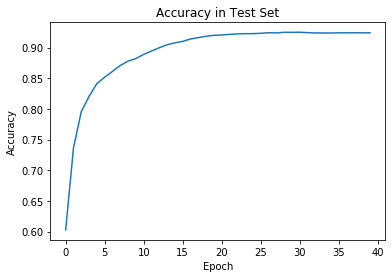

In [0]:
plt.title('Accuracy in Test Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(test_acc)

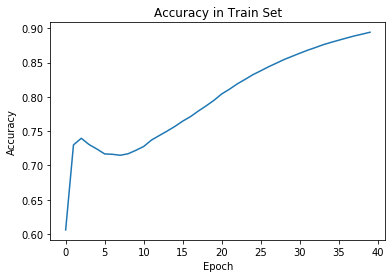

In [0]:
plt.title('Accuracy in Train Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc)

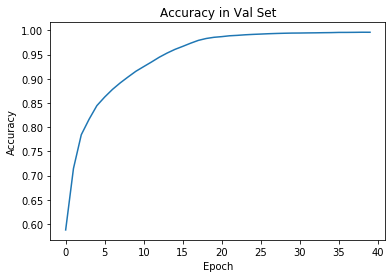

In [0]:
plt.title('Accuracy in Val Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(val_acc)

In [0]:
train_acc

[0.606,
 0.73,
 0.7396666666666667,
 0.7305,
 0.724,
 0.7168333333333333,
 0.7162857142857143,
 0.714875,
 0.7171111111111111,
 0.7221,
 0.7277272727272728,
 0.7370833333333333,
 0.7436923076923077,
 0.7501428571428571,
 0.757,
 0.7646875,
 0.7712941176470588,
 0.7793888888888889,
 0.7869473683959559,
 0.795,
 0.8043809523809524,
 0.8113181818181818,
 0.8190869565217391,
 0.825625,
 0.83248,
 0.8381153846153846,
 0.8439629629453024,
 0.84925,
 0.8545862068965517,
 0.8591333333333333,
 0.8637096774193549,
 0.86809375,
 0.872,
 0.8761470588235294,
 0.8795428571428572,
 0.88275,
 0.8859189189189189,
 0.8889736842105264,
 0.8915897435897436,
 0.894325]

In [0]:
test_acc

[0.6027,
 0.7362,
 0.7955,
 0.8205,
 0.8413,
 0.8517,
 0.8611,
 0.8709,
 0.8779,
 0.8821,
 0.8889,
 0.8943,
 0.8998,
 0.9046,
 0.9077,
 0.9101,
 0.914,
 0.9162,
 0.9185,
 0.92,
 0.9205,
 0.9215,
 0.9223,
 0.9227,
 0.9227,
 0.9233,
 0.9242,
 0.9239,
 0.9249,
 0.9248,
 0.925,
 0.9243,
 0.9239,
 0.9238,
 0.9238,
 0.9241,
 0.9241,
 0.9241,
 0.9241,
 0.924]

In [0]:
val_acc

[0.5875423728813559,
 0.7146034482758621,
 0.7842807017543859,
 0.8163214285714285,
 0.8445272727272727,
 0.8622777777777778,
 0.8780754716981132,
 0.8916538461538461,
 0.903843137254902,
 0.91558,
 0.9252040816326531,
 0.9347291666666667,
 0.9446595744680851,
 0.9532173913043478,
 0.9607777777777777,
 0.9670227272727273,
 0.9735116279069768,
 0.9794047619047619,
 0.9832926829268293,
 0.985775,
 0.9871538461538462,
 0.9889210526315789,
 0.9898108108108108,
 0.9909722222222223,
 0.9918,
 0.9924705882352941,
 0.9931818181818182,
 0.99371875,
 0.9941612903225806,
 0.9945,
 0.9946206896551724,
 0.9948571428571429,
 0.995037037037037,
 0.9953076923076923,
 0.99548,
 0.995875,
 0.9959130434782608,
 0.9960454545454546,
 0.9962380952380953,
 0.9962]

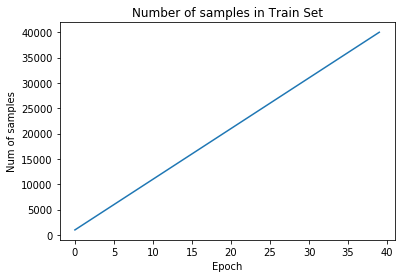

In [0]:
plt.title('Number of samples in Train Set')
plt.xlabel('Epoch')
plt.ylabel('Num of samples')
plt.plot(samplecount)